## Results of the first challenge

- announcement of results
- winners' talks
- feature engineering
- instabilities
- data leakage
- rule of thumb for selecting model: simplest among providing best results on tests

## Problems where close approaches are used

Linear models are very good at incorporating information from lots of simple features

- text categorization
- opinion mining
- internet advertisements
- basic recommendation systems

Many enhancements to linear models are possible.

The more data - the more complex models are possible. 

# Ensembling and stacking 

 - averaging works
 - combining similar classifiers doesn't make much sense
 - weighted voting is fine in many situations


# Recall about decision trees

In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from utils import plot_classifier_decision

X, y = make_blobs(n_samples=200, centers=[[0, 1], [2, 3]], random_state=14)

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


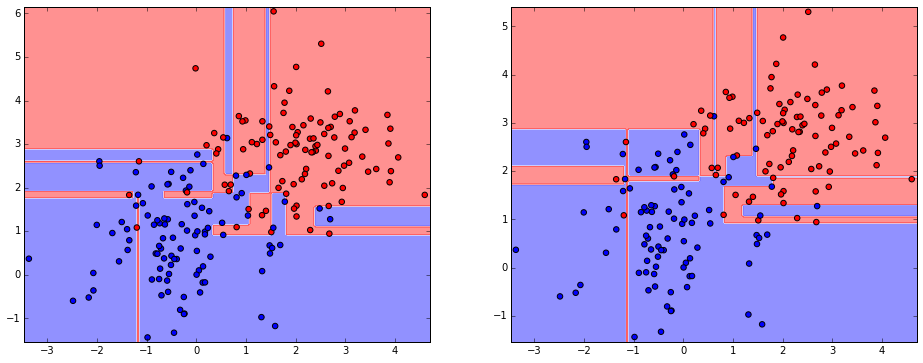

In [2]:
plt.figure(figsize=[16, 6])
plt.subplot(121)
tree = DecisionTreeClassifier(random_state=42).fit(X, y)
plot_classifier_decision(tree, X, y)
plt.subplot(122)
# same, but 20 events were removed
tree = DecisionTreeClassifier(random_state=42).fit(X[20:], y[20:])
plot_classifier_decision(tree, X[20:], y[20:])

# RandomForest

Builds independently many trees. 

Each tree is trained on a part of training data obtained by 
- sampling features (columns) without replacements (**Random Subspace Model**)
- sampling events (rows) with replacement (**bagging**)

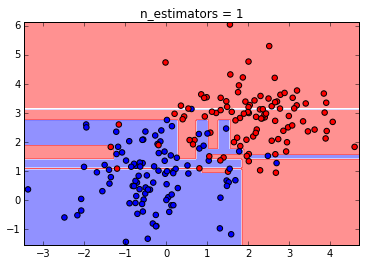

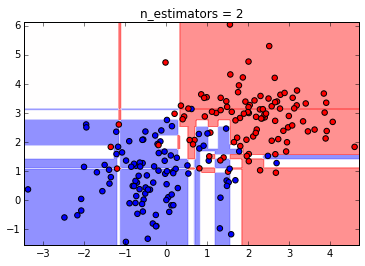

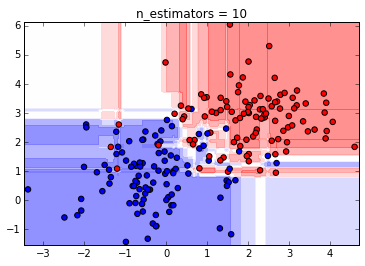

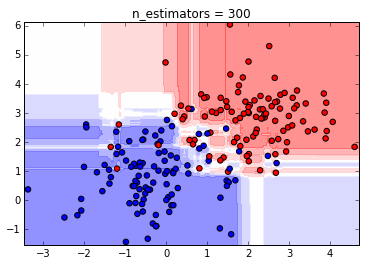

In [3]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
for n_trees in [1, 2, 10, 300]:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42).fit(X, y)
    plot_classifier_decision(rf, X, y)
    plt.title('n_estimators = {}'.format(n_trees))
    plt.show()

# Overfitting 

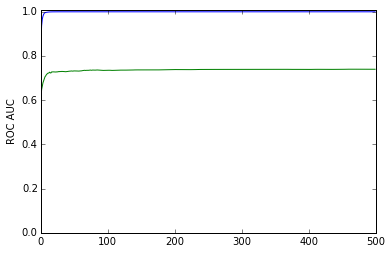

In [4]:
toy_trainX, toy_trainY = make_blobs(n_samples=2000, centers=[[0, 1, 1], [1, 2, 2]], random_state=42, cluster_std=1.5)
toy_testX,  toy_testY = make_blobs(n_samples=2000, centers=[[0, 1, 1], [1, 2, 2]], random_state=3, cluster_std=1.5)
rf = RandomForestClassifier(n_estimators=500).fit(toy_trainX, toy_trainY)


for toyX, toyY, label in [(toy_trainX, toy_trainY, 'train'), (toy_testX, toy_testY, 'test')]:
    predictions = numpy.zeros(len(toyX))
    curve = []
    for tree in rf.estimators_:
        predictions += tree.predict(toyX)
        curve.append(roc_auc_score(toyY, predictions))
    plt.plot(curve)
    plt.ylim(0, 1.01)
    plt.ylabel('ROC AUC')

### Random Forest
- terribly simple
- has huge difference of the quality between predictions on train and validation sample
- it's quality never goes down with increasing the number of trees
- **never overfits**
- huge difference between predictions on test and training does not guarantee the model is bad


But approach used by many physicists today (detect differenct between training and test) says 'it is overfitted' for random forest. So don't use this approach :)

<img src='http://arogozhnikov.github.io/images/etc/no_tmva_plot.gif' width='400' alt='these plots are not useful' />

## also...
- RF efficiently works with features of different scale and nature
- doesn't require tuning 
- for large datasets may produce giant trees (which is long and taked lots of memory). <br />
  Makes sense to limit growth of trees (`max_depth=30` or `min_samples_leaf`)
- works extremely well in many situations.

# Random forest for wines

taking the same splitting

In [5]:
import pandas
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
data = pandas.read_csv('data/2-winequality-white.csv', sep=';')
winesY = data['quality'].values
winesX = data.drop('quality', axis=1)
trainX, testX, trainY, testY = train_test_split(winesX, winesY, random_state=42)

rf_reg = RandomForestRegressor(n_estimators=200).fit(trainX, trainY)
mean_squared_error(testY, rf_reg.predict(testX))

0.35882079591836735

# AdaBoost (Adaptive Boosting, 1997) demonstration

AdaBoost operates by reweighting samples each time. <br />
Weight of sample is increased if base classifier makes a mistake.

Formally this corresponds to minimizing exponential loss function.
In the following demonstration we use trees of depth 1.

<!--- important note - illustration below gives the idea, but numerically incorrect -->

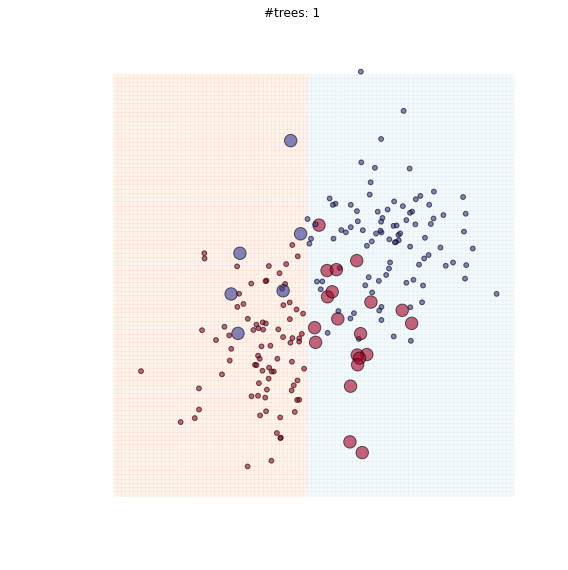

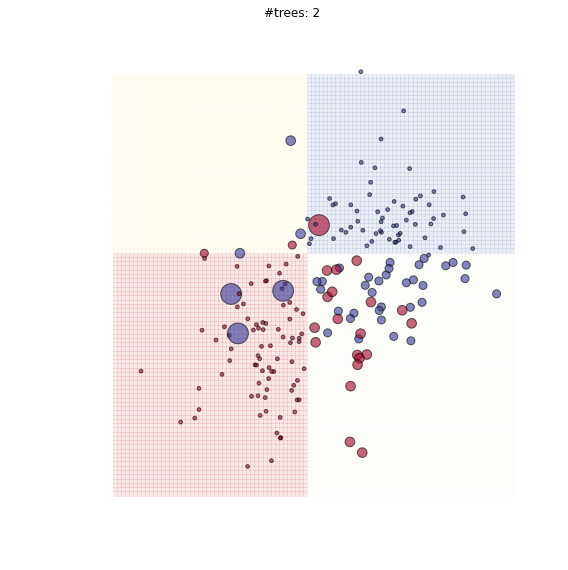

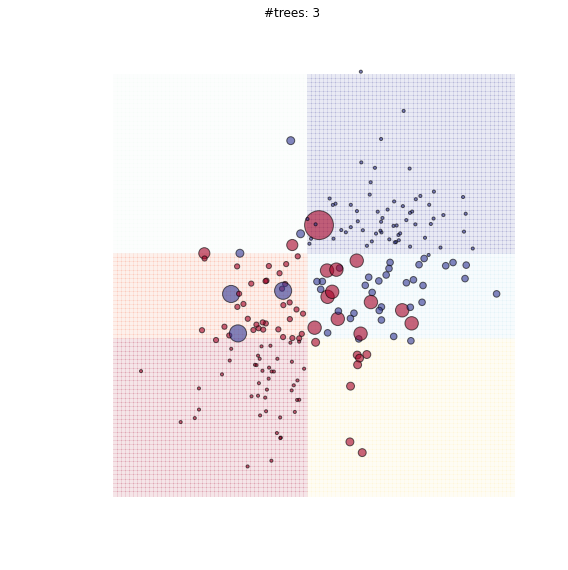

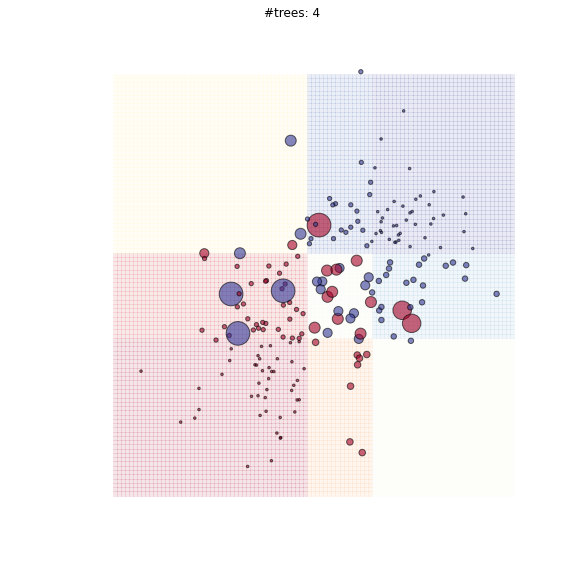

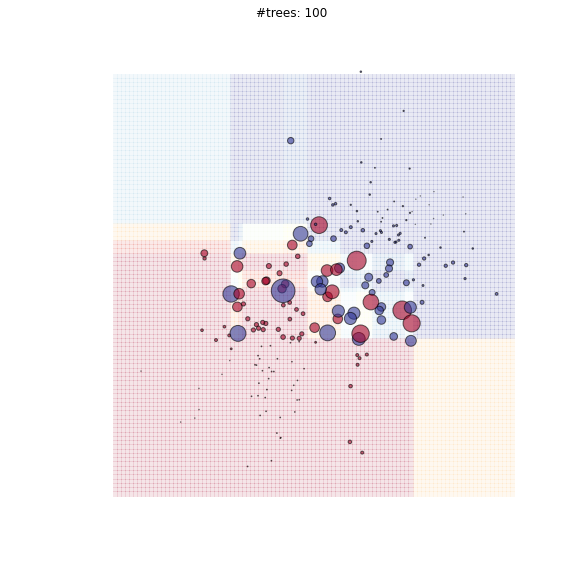

In [6]:
# Hand-made AdaBoost! It's quite simple!
xx, yy = numpy.meshgrid(numpy.linspace(-4, 5, 100), numpy.linspace(-2, 6, 100))
weights = numpy.ones(len(X))
Z = 0 * xx.flatten()
Z[0] = 0.1
Z[-1] = -0.1

for iteration in range(101):
    if iteration in [1, 2, 3, 4, 100]:
        plt.figure(figsize=[8, 8])
        plt.pcolormesh(xx, yy, Z.reshape(xx.shape),  alpha=0.1, cmap='RdYlBu', vmin=-2, vmax=2)
        plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.6, s=40 * weights / weights.mean(), cmap='RdYlBu')
        plt.axis('off')
        plt.title('#trees: {}'.format(iteration))
        plt.tight_layout()
    

    tree = DecisionTreeClassifier(max_depth=1).fit(X, y, sample_weight=weights)
    is_correct = (y == tree.predict(X))
    alpha = 0.5 * numpy.log(numpy.sum(is_correct * weights) / numpy.sum((1 - is_correct) * weights))
    weights *= numpy.exp(- alpha * (2 * is_correct - 1))
    Z = Z + alpha * (2 * tree.predict(numpy.c_[xx.ravel(), yy.ravel()]) - 1)

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
clf = AdaBoostClassifier(n_estimators=100, 
                         base_estimator=DecisionTreeClassifier(max_depth=3))
# you can train AdaBoost over other classifiers

clf = AdaBoostClassifier(n_estimators=100, 
                         base_estimator=GaussianNB())

# GB demonstration

GBDT approximates target dependency by making steps in the space of functions:

<img src='http://arogozhnikov.github.io/images/etc/rogozhnikov_gb_visualization.png' />

# GB tuning

AdaBoost is a particular case of Gradient Boosting.

Sklearn's [tutorial](http://nbviewer.jupyter.org/urls/s3.amazonaws.com/datarobotblog/notebooks/gbm-tutorial.ipynb) on tuning GBDT.

GB = GBDT = GBRT = GBM = MART, these are names of same approach.

## Working with GB in sklearn

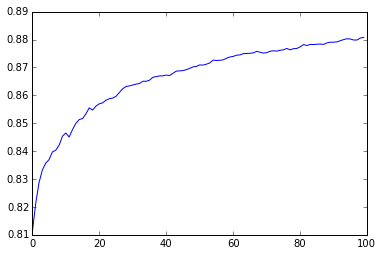

In [8]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
new_trainY = trainY > 6
new_testY = testY > 6
gb_clf.fit(trainX, new_trainY)

test_qualities = []
for p in gb_clf.staged_predict_proba(testX):
    test_qualities.append(roc_auc_score(new_testY, p[:, 1]))
plt.plot(test_qualities)

# Higgs sample submission using RandomForest

To make challenge even more physical, the data is stored in ROOT - beloved format in HEP. <br />
ROOT keeps your data fresh and healthy! (joking)



In [69]:
from IPython.display import FileLink
#def create_solution(predictions, filename='2-higgs-decay-predictions.csv'):
#    result = pandas.DataFrame({'EventId': numpy.arange(len(predictions)), 'Label': predictions})
#    result.to_csv('data/{}'.format(filename), index=False)
#    return FileLink('data/{}'.format(filename))
def create_solution(predictions, filename='3-higgs-decay-predictions.csv'):
    result = pandas.DataFrame({'EventId': numpy.arange(len(predictions)), 'Label': predictions})
    result.to_csv('data/{}'.format(filename), index=False, float_format='%1.5f')
    path = 'data/{}'.format(filename)
    !gzip --force -9 $path
    return FileLink('{}.gz'.format(path))

In [86]:
import root_numpy

all_train = pandas.DataFrame(root_numpy.root2array('./data/3-Higgs_training.root', treename='data'))

y = all_train.Label.values
w = all_train.Weight.values
X = all_train.drop(['Label', 'Weight'], axis=1)

In [87]:
trainX, testX, trainY, testY, trainW, testW = train_test_split(X, y, w, random_state=42)

In [88]:
trainX.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
90842,133.931,37.435,105.231,101.530,4.690,644.736,-4.515,2.900,29.498,261.915,...,2.952,309.313,2,76.615,-3.337,1.221,49.352,1.353,-0.774,125.967
208668,118.685,80.239,94.042,139.889,1.108,167.790,-0.270,2.284,60.418,375.339,...,-0.346,430.095,3,104.532,-0.362,2.587,83.686,0.746,-2.231,224.572
120293,100.818,84.426,84.290,0.141,-999.000,-999.000,-999.000,2.554,0.141,88.558,...,-2.785,78.788,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
98990,82.025,4.392,45.541,114.083,-999.000,-999.000,-999.000,1.264,1.488,193.378,...,2.049,258.721,1,113.710,-1.088,-1.489,-999.000,-999.000,-999.000,113.710
194631,99.361,17.711,55.792,69.790,-999.000,-999.000,-999.000,2.101,2.403,131.293,...,3.089,157.375,1,67.486,1.100,-0.379,-999.000,-999.000,-999.000,67.486


In [89]:
test_data = pandas.DataFrame(root_numpy.root2array('./data/3-Higgs_test.root', treename='data'))
test_data = test_data.drop('EventId', axis=1)

In [90]:
test_data.columns

Index([u'DER_mass_MMC', u'DER_mass_transverse_met_lep', u'DER_mass_vis',
       u'DER_pt_h', u'DER_deltaeta_jet_jet', u'DER_mass_jet_jet',
       u'DER_prodeta_jet_jet', u'DER_deltar_tau_lep', u'DER_pt_tot',
       u'DER_sum_pt', u'DER_pt_ratio_lep_tau', u'DER_met_phi_centrality',
       u'DER_lep_eta_centrality', u'PRI_tau_pt', u'PRI_tau_eta',
       u'PRI_tau_phi', u'PRI_lep_pt', u'PRI_lep_eta', u'PRI_lep_phi',
       u'PRI_met', u'PRI_met_phi', u'PRI_met_sumet', u'PRI_jet_num',
       u'PRI_jet_leading_pt', u'PRI_jet_leading_eta', u'PRI_jet_leading_phi',
       u'PRI_jet_subleading_pt', u'PRI_jet_subleading_eta',
       u'PRI_jet_subleading_phi', u'PRI_jet_all_pt'],
      dtype='object')

In [15]:
clf = RandomForestClassifier(n_estimators=10, max_depth=30)
# don't forget to compute quality on cross-validation!
clf.fit(trainX, trainY, sample_weight=trainW)

create_solution(clf.predict_proba(test_data)[:, 1])

0.783697422368


/notebooks/MLatImperial2016/data/2-higgs-decay-predictions.csv

In [21]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

print roc_auc_score(testY, clf.predict_proba(testX)[:, 1], sample_weight=testW)
print mean_squared_error(testY, clf.predict_proba(testX)[:, 1], sample_weight=testW)

0.751681467678
0.00853573944066


To be submitted to the [kaggle competition](https://inclass.kaggle.com/c/higgs-competition)


## Weights in Machine Learning

- weights are proportional to probabilities 
- weights are always non-negative (sWeights are not weights!)
- being put in ML, they drive to different problems (i.e. non-convex optimization losses)
- heuristically sWeights may work
- avoid using negative weights

## Stacking (stacked generalization)

<img src='http://arogozhnikov.github.io/images/etc/rogozhnikov_stacking.png' />

# Homework (due to Wednesday, 3rd Feb)

** Exercise #0. ** Compare results of well-tuned decision tree and stock RandomForest with 300 trees on Higgs Dataset. Submit both to the kaggle.

** Exercise #1. ** Look at feature importances of RandomForest. (use `clf.feature_importances_`)

** Exercise #2. ** (Optional) Are you able to provide comparable quality of classification with linear models?
    (Take a linear model and provide it with new features)

** Major Goal. ** Participate in Higgs kaggle (shall be approved soon)! Don't forget about feature engineering.

When done, save the changes and download notebook. Rename to `3 - Surname - ensembling.ipynb` and send to `icl.ml@yandex.ru`

## Exercise #0

In [19]:
## Stock Randomforest with 300 trees
clf = RandomForestClassifier(n_estimators=300, max_depth=30)
# don't forget to compute quality on cross-validation!
clf.fit(trainX, trainY, sample_weight=trainW)

create_solution(clf.predict_proba(test_data)[:, 1])

/notebooks/MLatImperial2016/data/2-higgs-decay-predictions.csv

In [21]:
print roc_auc_score(testY, clf.predict_proba(testX)[:, 1], sample_weight=testW)

0.750642647651


In [17]:
## well tuned decision tree with 300 trees
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import KFold

# min_samples_leaf 
# min_samples_split 
# max_depth

qualities_depth=[]

# for train_indices, test_indices in KFold(len(X), n_folds=3):
#    fold_trainX = X.iloc[train_indices, :]
#    fold_testX  = X.iloc[test_indices, :]
#    fold_trainY = y[train_indices]
#    fold_testY  = y[test_indices]
#    fold_trainW = w[train_indices]
#    fold_testW = w[test_indices]
    
for depth in [10, 20, 30]:
    for min_samples_leaf in [50, 100, 200]:
        for min_samples_split in [100, 200, 300]:
            tree_reg = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=min_samples_leaf,
                                         min_samples_split=min_samples_split, random_state=42)
            tree_reg.fit(trainX, trainY, sample_weight=trainW)
            qualities_depth.append([depth, min_samples_leaf, min_samples_split, 
                                    mean_squared_error(testY, tree_reg.predict(testX))])
            qualities_depth_pd=pd.DataFrame(qualities_depth, columns=["max_depth", 'min_samples_leaf', 'min_samples_split', 'mean_squared_error'])
    
qualities_depth_pd

,max_depth,min_samples_leaf,min_samples_split,mean_squared_error
0,10,50,100,0.325944
1,10,50,200,0.326571
2,10,50,300,0.326938
3,10,100,100,0.325223
4,10,100,200,0.325223
5,10,100,300,0.325607
6,10,200,100,0.326475
7,10,200,200,0.326475
8,10,200,300,0.326475
9,20,50,100,0.303179


In [18]:
tree_reg = DecisionTreeRegressor(max_depth=20, min_samples_leaf=50,
                             min_samples_split=100, random_state=42)
tree_reg.fit(trainX, trainY, sample_weight=trainW)
mean_squared_error(testY, tree_reg.predict(testX))

create_solution(tree_reg.predict(test_data))


/notebooks/MLatImperial2016/data/2-higgs-decay-predictions.csv

In [91]:
#change weights
trainW_u=trainW.copy()
trainW_u[trainY==1] = trainW[trainY==1]*1000

testW_u = testW.copy()
testW_u[testY==1] = testW[testY==1]*1000


In [102]:
clf_2 = RandomForestClassifier(n_estimators=300, max_depth=30)
# don't forget to compute quality on cross-validation!
clf_2.fit(trainX, trainY, sample_weight=trainW_u)
print roc_auc_score(testY, clf_2.predict_proba(testX)[:, 1], sample_weight=testW_u)

create_solution(clf_2.predict_proba(test_data)[:, 1])

0.914711692379


/notebooks/MLatImperial2016/data/3-higgs-decay-predictions.csv.gz

In [48]:
print mean_squared_error(testY, clf_2.predict_proba(testX)[:, 1], sample_weight=testW_u)

0.129817656363


## Exercise 1

In [70]:
RF_results = pd.DataFrame(zip(trainX.columns, clf.feature_importances_), columns=["feature", "value"]).sort_values('value',ascending=False)

In [71]:
RF_results

,feature,value
1,DER_mass_transverse_met_lep,0.066027
15,PRI_tau_phi,0.057078
18,PRI_lep_phi,0.054364
0,DER_mass_MMC,0.051640
13,PRI_tau_pt,0.050791
20,PRI_met_phi,0.050462
19,PRI_met,0.049085
10,DER_pt_ratio_lep_tau,0.048434
16,PRI_lep_pt,0.048223
2,DER_mass_vis,0.047988


In [73]:
RF_results_u = pd.DataFrame(zip(trainX.columns, clf_2.feature_importances_), columns=["feature", "value"]).sort_values('value',ascending=False)

In [74]:
RF_results_u

,feature,value
0,DER_mass_MMC,0.160318
1,DER_mass_transverse_met_lep,0.141141
2,DER_mass_vis,0.086149
13,PRI_tau_pt,0.060956
10,DER_pt_ratio_lep_tau,0.058635
7,DER_deltar_tau_lep,0.049915
19,PRI_met,0.049195
11,DER_met_phi_centrality,0.046561
16,PRI_lep_pt,0.029945
3,DER_pt_h,0.029832


## Exercise 2

In [173]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

clf_scaleX = StandardScaler().fit(trainX).transform(trainX)
clf_scaleTX = StandardScaler().fit(testX).transform(testX)

clf = SGDClassifier(loss='log', n_iter=100)
clf.fit(clf_scaleX, trainY, sample_weight=trainW)
roc_auc_score(testY, clf.predict_proba(clf_scaleTX)[:, 1], sample_weight=testW)

0.5

In [152]:

from sklearn.linear_model import LogisticRegression
lin_clf = LogisticRegression(C=100)
lin_clf.fit(trainX, trainY) # logistic regression doesn't support sample_weight
print roc_auc_score(testY, lin_clf.predict_proba(testX)[:, 1], sample_weight=testW)

0.842030942522


In [35]:
## adding new features
from sklearn.preprocessing import StandardScaler

X_extend = StandardScaler().fit(X).transform(X)
X_extend = pandas.DataFrame(X_extend, columns=X.columns)

# for f in X_extend.columns:
#    X_extend[f + '_abs']  = numpy.abs(X_extend[f])
#    X_extend[f + '_tanh'] = numpy.tanh(X_extend[f])
#    X_extend[f + '_log'] = numpy.log(X_extend[f])



In [36]:
trainX_extended, testX_extended = train_test_split(X_extend, random_state=42)

In [54]:
## Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd

qualities_depth=[]
for max_depth in [2, 4, 8]:
    for min_samples_leaf in [10, 50, 100]:
        for min_samples_split in [50, 100, 200]:
            print min_samples_split
            GDB_clf = GradientBoostingClassifier(n_estimators=100, max_depth=max_depth, 
                                                 min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
            GDB_clf.fit(trainX, trainY)
            mean_squared_error(testY, GDB_clf.predict_proba(testX)[:,1])

            qualities_depth.append([max_depth, min_samples_leaf, min_samples_split, 
                                        mean_squared_error(testY, GDB_clf.predict_proba(testX)[:,1])])
            qualities_depth_pd=pd.DataFrame(qualities_depth, 
                                            columns=["max_depth", 'min_samples_leaf', 'min_samples_split', 'mean_squared_error'])

qualities_depth_pd



50
100
200
50
100
200
50
100
200
50
100
200
50
100
200
50
100
200
50
100
200
50
100
200
50
100
200


,max_depth,min_samples_leaf,min_samples_split,mean_squared_error
0,2,10,50,0.124859
1,2,10,100,0.124859
2,2,10,200,0.124859
3,2,50,50,0.124859
4,2,50,100,0.124859
5,2,50,200,0.124859
6,2,100,50,0.124859
7,2,100,100,0.124859
8,2,100,200,0.124859
9,4,10,50,0.114834


In [56]:
GDB_clf = GradientBoostingClassifier(n_estimators=100, max_depth=8, 
                                                 min_samples_leaf=100, min_samples_split=50, subsample=0.5)
GDB_clf.fit(trainX, trainY)
mean_squared_error(testY, GDB_clf.predict_proba(testX)[:,1])

0.11146065949011358

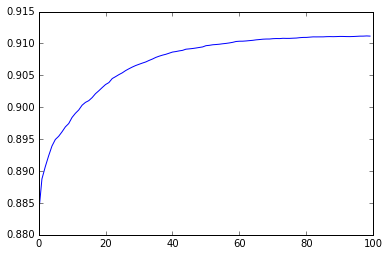

In [57]:
test_qualities = []
for p in GDB_clf.staged_predict_proba(testX):
    test_qualities.append(roc_auc_score(testY, p[:, 1]))
plt.plot(test_qualities)

In [60]:
GDB_clf = GradientBoostingClassifier(n_estimators=100, max_depth=4, 
                                                 min_samples_leaf=100, min_samples_split=50, learning_rate=0.05)
GDB_clf.fit(trainX, trainY)
mean_squared_error(testY, GDB_clf.predict_proba(testX)[:,1])


0.11855590903265048

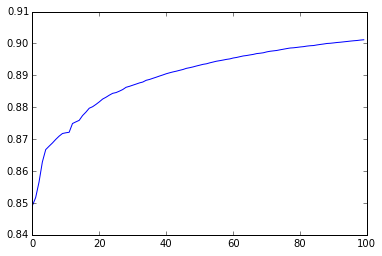

In [61]:
test_qualities = []
for p in GDB_clf.staged_predict_proba(testX):
    test_qualities.append(roc_auc_score(testY, p[:, 1]))
plt.plot(test_qualities)

In [63]:
GDB_clf = GradientBoostingClassifier(loss='exponential', n_estimators=100, max_depth=4, 
                                                 min_samples_leaf=100, min_samples_split=50)
GDB_clf.fit(trainX, trainY)
mean_squared_error(testY, GDB_clf.predict_proba(testX)[:,1])


0.1148393798855771

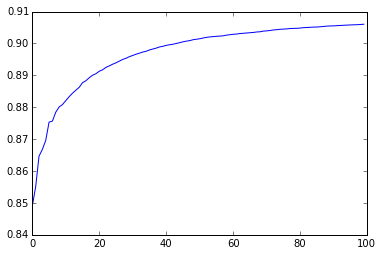

In [64]:
test_qualities = []
for p in GDB_clf.staged_predict_proba(testX):
    test_qualities.append(roc_auc_score(testY, p[:, 1]))
plt.plot(test_qualities)

In [65]:
GDB_clf = GradientBoostingClassifier(loss='exponential', n_estimators=500, max_depth=4, 
                                                 min_samples_leaf=100, min_samples_split=50)
GDB_clf.fit(trainX, trainY)
mean_squared_error(testY, GDB_clf.predict_proba(testX)[:,1])


0.11179697594194693

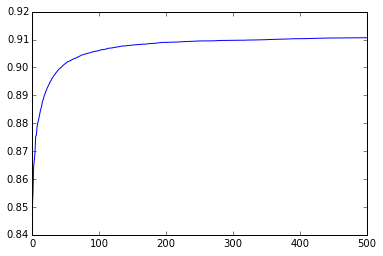

In [66]:
test_qualities = []
for p in GDB_clf.staged_predict_proba(testX):
    test_qualities.append(roc_auc_score(testY, p[:, 1]))
plt.plot(test_qualities)

In [68]:
create_solution(GDB_clf.predict_proba(test_data)[:,1])

/notebooks/MLatImperial2016/data/2-higgs-decay-predictions.csv

In [75]:
GDB_clf = GradientBoostingClassifier(n_estimators=1000, max_depth=1, 
                                                 min_samples_leaf=100, min_samples_split=50, subsample=0.5)
GDB_clf.fit(trainX, trainY, sample_weight=trainW)
mean_squared_error(testY, GDB_clf.predict_proba(testX)[:,1])


0.33118415965316317

In [81]:
GDB_clf.score(testX, testY, sample_weight=testW)

0.99910520749343457

In [ ]:
test_qualities = []
for p in GDB_clf.staged_predict_proba(testX):
    test_qualities.append(roc_auc_score(testY, p[:, 1]))
plt.plot(test_qualities)

In [ ]:
GDB_clf = GradientBoostingClassifier(n_estimators=200, max_depth=8, 
                                                 min_samples_leaf=100, min_samples_split=50)
GDB_clf.fit(trainX, trainY)
mean_squared_error(testY, GDB_clf.predict_proba(testX)[:,1])

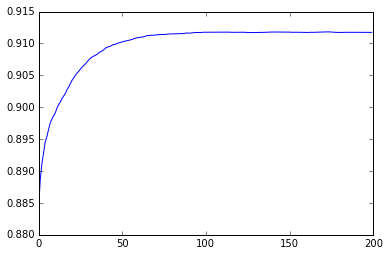

In [73]:
test_qualities = []
for p in GDB_clf.staged_predict_proba(testX):
    test_qualities.append(roc_auc_score(testY, p[:, 1]))
plt.plot(test_qualities)

In [82]:
create_solution(GDB_clf.predict_proba(test_data)[:,1])

/notebooks/MLatImperial2016/data/3-higgs-decay-predictions.csv.gz

## Homework 4, Exercise 1

In [ ]:
## Gradient Boosting
## consider weights
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd

qualities_depth=[]
for max_depth in [2, 4, 8]:
    for min_samples_leaf in [10, 50, 100]:
        for min_samples_split in [50, 100, 200]:
            print min_samples_split
            GDB_clf = GradientBoostingClassifier(n_estimators=100, max_depth=max_depth, 
                                                 min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
            GDB_clf.fit(trainX, trainY, sample_weight=trainW_u)
            mean_squared_error(testY, GDB_clf.predict_proba(testX)[:,1])

            qualities_depth.append([max_depth, min_samples_leaf, min_samples_split, 
                                    mean_squared_error(testY, GDB_clf.predict_proba(testX)[:,1]), 
                                    GDB_clf.score(testX, testY, sample_weight=testW_u)])
            qualities_depth_pd=pd.DataFrame(qualities_depth, 
                                            columns=["max_depth", 'min_samples_leaf', 'min_samples_split', 'mean_squared_error', 'score'])

qualities_depth_pd



In [84]:
qualities_depth_pd

,max_depth,min_samples_leaf,min_samples_split,mean_squared_error,score
0,2,10,50,0.329079,0.998997
1,2,10,100,0.329079,0.998997
2,2,10,200,0.329079,0.998997
3,2,50,50,0.328171,0.999076
4,2,50,100,0.328171,0.999076
5,2,50,200,0.328171,0.999076
6,2,100,50,0.328702,0.999106
7,2,100,100,0.328702,0.999106
8,2,100,200,0.328702,0.999106
9,4,10,50,0.318079,0.998224


In [98]:
GDB_clf = GradientBoostingClassifier(n_estimators=200, max_depth=8, 
                                                 min_samples_leaf=100, min_samples_split=50)
GDB_clf.fit(trainX, trainY, sample_weight=trainW_u)



0.83766580525555812

In [197]:
print roc_auc_score(testY, GDB_clf.predict_proba(testX)[:,1], sample_weight=testW)

0.919690053436


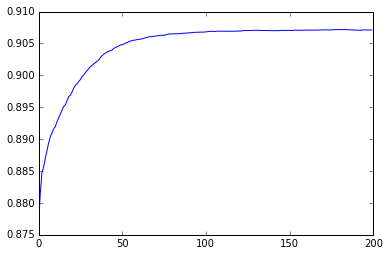

In [99]:
test_qualities = []
for p in GDB_clf.staged_predict_proba(testX):
    test_qualities.append(roc_auc_score(testY, p[:, 1]))
plt.plot(test_qualities)

In [94]:
create_solution(GDB_clf.predict_proba(test_data)[:,1])

/notebooks/MLatImperial2016/data/3-higgs-decay-predictions.csv.gz

In [103]:
def objfunction(x):
    return mean_squared_error(testY, (x[0]*GDB_clf.predict_proba(testX)[:,1] + x[1]*clf_2.predict_proba(testX)[:,1]))

In [ ]:
def objfunction_log(x):
    return mean_squared_error(testY, 1/((1+exp(x[0]*GDB_clf.predict_proba(testX)[:,1] + x[1]*clf_2.predict_proba(testX)[:,1])))

In [104]:
from scipy.optimize import minimize
import pandas as pd
import numpy as np

#one minus the sum of all variables must be zero
cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})

#Required to have non negative values
bnds = ((0, 1), (0, 1))

res = minimize(objfunction, np.asarray([0.5, 0.5]), bounds=bnds ,constraints=cons)



In [105]:
res

  status: 0
 success: True
    njev: 5
    nfev: 20
     fun: 0.1138134680572714
       x: array([ 0.26769479,  0.73230521])
 message: 'Optimization terminated successfully.'
     jac: array([ 0.00933288,  0.00933287,  0.        ])
     nit: 5

In [109]:
create_solution(GDB_clf.predict_proba(test_data)[:,1]*0.26769479 + clf_2.predict_proba(test_data)[:,1]*0.73230521)

/notebooks/MLatImperial2016/data/3-higgs-decay-predictions.csv.gz

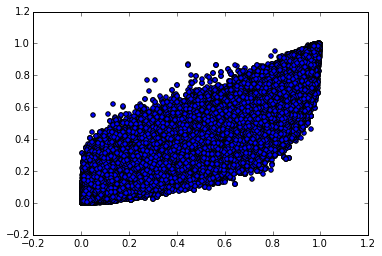

In [110]:
plt.scatter(GDB_clf.predict_proba(test_data)[:,1], clf_2.predict_proba(test_data)[:,1])

## relationship  between GBDT and RF is linearly correlated

## Exercise 2 of homework 4

In [188]:
# check best GBDT and RF results 
print roc_auc_score(testY, GDB_clf.predict_proba(testX)[:,1], sample_weight=testW)
print roc_auc_score(testY, clf_2.predict_proba(testX)[:,1], sample_weight=testW)


0.919690053436
0.914711358919


In [134]:
# try stacking them together
stacked = pd.DataFrame([])
stacked['GBDT']= GDB_clf.predict_proba(trainX)[:,1]
stacked['RF']= clf_2.predict_proba(trainX)[:,1]


In [156]:
# try fitting using logistic regression
from sklearn.linear_model import LogisticRegression
bclf = LogisticRegression()
bclf.fit(stacked, trainY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [189]:
stacked_testX = pd.DataFrame([])
stacked_testX['GBDT']= GDB_clf.predict_proba(testX)[:,1]
stacked_testX['RF']= clf_2.predict_proba(testX)[:,1]

pre_textX = bclf.predict_proba(stacked_testX)
print roc_auc_score(testY, pre_textX[:,1], sample_weight=testW)

0.888001054111


In [ ]:
## Logistic regression results are not good enough

In [190]:
## Try linear regression, results are better but still not good enough
from sklearn.linear_model import LinearRegression
Lclf = LinearRegression()
Lclf.fit(stacked, trainY)

pre_textX = Lclf.predict(stacked_testX)
print roc_auc_score(testY, pre_textX, sample_weight=testW)


0.89574834518


In [196]:
# try regularized linear models with stochastic gradient descent (SGD) learning
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

SGDCclf = SGDClassifier(loss='log', n_iter=100)
SGDCclf.fit(stacked, trainY, sample_weight=trainW)
roc_auc_score(testY, SGDCclf.predict_proba(stacked_testX)[:, 1], sample_weight=testW)


0.91846538608289974

In [140]:
stacked_testdata = pd.DataFrame([])
stacked_testdata['GBDT']= GDB_clf.predict_proba(test_data)[:,1]
stacked_testdata['RF']= clf_2.predict_proba(test_data)[:,1]

In [182]:
create_solution(SGDCclf.predict_proba(stacked_testdata)[:,1])

/notebooks/MLatImperial2016/data/3-higgs-decay-predictions.csv.gz

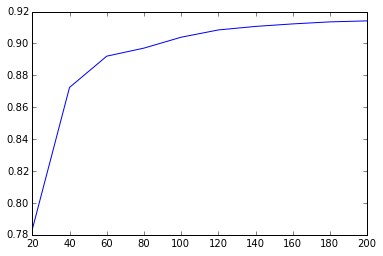

In [204]:
from rep.estimators import XGBoostClassifier

# parameters are bad, tune them!
xgb = XGBoostClassifier(n_estimators=200, nthreads=4, eta=0.1, subsample=0.5, colsample=0.2) 
xgb.fit(trainX, trainY, sample_weight=trainW)

learning_curve = []
step = xgb.n_estimators // 10
for probs in xgb.staged_predict_proba(testX.astype('float64'), step=step):
    learning_curve.append(roc_auc_score(testY, probs[:, 1], sample_weight=testW))

# plotting learning curve
plt.plot((numpy.arange(len(learning_curve)) + 1) * step, learning_curve)

In [205]:
print roc_auc_score(testY, xgb.predict_proba(testX)[:,1], sample_weight=testW)


0.914179374911


In [144]:
import sklearn
sklearn.__version__

'0.16.1'